In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt  
from numpy import linalg
import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [5]:
class SVM(object):
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print('{0} support vectors out of {1} points'.format(len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
    
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))
    

     pcost       dcost       gap    pres   dres
 0: -1.5998e+03 -3.2607e+03  2e+03  5e-14  2e+00
 1: -3.9022e+03 -3.9429e+03  4e+01  4e-14  1e+00
 2: -3.7845e+05 -3.7849e+05  4e+01  2e-12  1e+00
 3: -3.5782e+09 -3.5782e+09  5e+03  1e-07  1e+00
 4: -1.4390e+10 -1.4390e+10  2e+04  5e-07  1e+00
Terminated (singular KKT matrix).
1600 support vectors out of 1600 points
198 out of 400 predictions correct


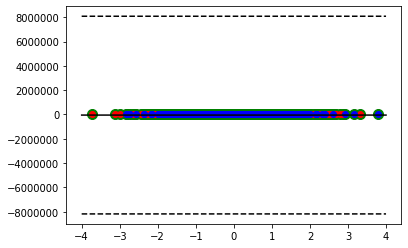

In [12]:
if __name__ == "__main__":
    import matplotlib.pyplot as pl
    
    def plot_margin(X1_train, X2_train, clf):
        
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]
        
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
        
        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")
        
        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")
        
        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")
        
        plt.axis = ([-1,1,-1,1])
    
        pl.show()
    
    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
        
        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
        
        plt.axis = ([-1,1,-1,1])
        pl.show()
    
    def test_linear(X_train, y_train,X_test,y_test):
        
        clf = SVM()
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        
        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)
              
    def test_non_linear(X_train, y_train,X_test,y_test):
        
        clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
    
    def test_soft(X_train, y_train,X_test,y_test):
        
        clf = SVM(C=0.1)
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
    
    data = pd.read_csv("hw2data.csv",header = None) 
    samples = np.array(data)
    #shuffle [X,y]
    np.random.shuffle(samples)
    
    flag = np.int(0.8*len(samples))
      
    X_train = samples[:flag,:-1]
    X_test = samples[flag:,:-1]
    y_train = samples[:flag,-1]
    y_test = samples[flag:,-1]
    
    #test_soft()
    test_linear(X_train, y_train,X_test,y_test)
    #test_non_linear()